# SageMaker Real-Time Inference vs Serverless Inference comparison
## XGBoost Regression Example

For this notebook we'll be working with the SageMaker XGBoost Algorithm to train a model and then deploy a serverless endpoint. We will be using the public S3 Abalone regression dataset for this example.

<b>Notebook Setting</b>
- <b>SageMaker Classic Notebook Instance</b>: ml.m5.xlarge Notebook Instance & conda_python3 Kernel
- <b>SageMaker Studio</b>: Python 3 (Data Science)


## Table of Contents
- Setup
- Model upload
- Deployment of real-time inference endpoint using SageMaker SDK 
    - Model Creation
    - Endpoint Deployment
    - Endpoint Invocation
    - Endpoint Latency Distribution Analysis
- Deployment of real-time inference endpoint using Boto3  
    - Model Creation
    - Endpoint Configuration
    - Endpoint Deployment
    - Endpoint Latency Distribution Analysis
- Cleanup

## Setup

For testing you need to properly configure your Notebook Role to have <b>SageMaker Full Access</b>.

Let's start by installing preview wheels of the Python SDK, boto and aws cli

In [1]:
#! pip install sagemaker botocore boto3 awscli --upgrade

In [2]:
# Setup clients
import boto3

client = boto3.client(service_name="sagemaker")
runtime = boto3.client(service_name="sagemaker-runtime")

### SageMaker Setup
To begin, we import the AWS SDK for Python (Boto3) and set up our environment, including an IAM role and an S3 bucket to store our data.

In [3]:
import boto3
import sagemaker
from sagemaker.estimator import Estimator
import os
#from os.path import join

boto_session = boto3.session.Session()
region = boto_session.region_name
print(region)

sagemaker_session = sagemaker.Session()
base_job_prefix = "xgboost-example"
role = sagemaker.get_execution_role()
print(role)

default_bucket = sagemaker_session.default_bucket()
s3_prefix = base_job_prefix

us-west-2
arn:aws:iam::328296961357:role/service-role/AmazonSageMaker-ExecutionRole-20191125T182032


#### We are not going to run through model training steps, but rather use an already-trained model. The XGBoost model used in ths example was trained on a publicly-available "abalone" dataset.

In [4]:
# retrieve data
#! curl https://sagemaker-sample-files.s3.amazonaws.com/datasets/tabular/uci_abalone/train_csv/abalone_dataset1_train.csv > abalone_dataset1_train.csv

## Model Deployment

In [5]:
#upload model to S3 bucket.
#SageMaker Model class accepts an S3 URI as input for model.tar.gz file, thus we need to upload the model to S3.
#https://sagemaker.readthedocs.io/en/stable/api/inference/model.html#sagemaker.model.Model
s3_prefix = os.path.join(base_job_prefix, "xgb_model")
s3_model_path=sagemaker_session.upload_data(path="model", bucket=default_bucket, key_prefix=s3_prefix)
model_artifacts=os.path.join(s3_model_path, "model.tar.gz")


### Creating and Deploying a Model using SageMaker Python SDK
Create a model by providing your model artifacts, the container image URI, environment variables for the container (if applicable), a model name, and the SageMaker IAM role.

In [6]:
from sagemaker import model

# retrieve xgboost docker container image from AWA ECR (Elastic Container Registry)
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.0-1",
    py_version="py3"
)

print(image_uri)

#Initialize SageMaker model.
inference_model = model.Model(
    image_uri=image_uri, 
    model_data=model_artifacts,
    role=role,
    sagemaker_session=sagemaker_session,
#    vpc_config = vpc_confg,
#    enable_network_isolation = False,
#    model_kms_key=model_kms_key,
)

246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3


In [7]:
%%time
#Deploy SageMaker model on an endpoint.
from time import gmtime, strftime
realtime_endpoint_name = "xgboost-ep-sdk-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
predictor_sdk=inference_model.deploy(
    initial_instance_count = 1,
    instance_type='ml.c4.xlarge',
    endpoint_name=realtime_endpoint_name,
#    serializer,
#    deserializer,
#    kms_key=None,
#    wait=True,
    )

---------!CPU times: user 122 ms, sys: 21.6 ms, total: 144 ms
Wall time: 4min 31s


### Creating and Deploying the same model as a Serverless Endpoint via Boto3 SDK
Create a model by providing your model artifacts, the container image URI, environment variables for the container (if applicable), a model name, and the SageMaker IAM role.

In [8]:
from time import gmtime, strftime

serverless_model_name = "xgboost-serverless-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name: " + serverless_model_name)

# dummy environment variables
byo_container_env_vars = {"SAGEMAKER_CONTAINER_LOG_LEVEL": "20", "SOME_ENV_VAR": "myEnvVar"}

create_model_response = client.create_model(
    ModelName=serverless_model_name,
    Containers=[
        {
            "Image": image_uri,
            "Mode": "SingleModel",
            "ModelDataUrl": model_artifacts,
            "Environment": byo_container_env_vars,
        }
    ],
    ExecutionRoleArn=role,
)

print("Model Arn: " + create_model_response["ModelArn"])

Model name: xgboost-serverless-2022-01-26-17-33-52
Model Arn: arn:aws:sagemaker:us-west-2:328296961357:model/xgboost-serverless-2022-01-26-17-33-52


### Creating Serverless Endpoint Configuration 

This is where you can adjust the <b>Serverless Configuration</b> for your endpoint. The current max concurrent invocations for a single endpoint, known as <b>MaxConcurrency</b>, can be any value from <b>1 to 50</b>, and <b>MemorySize</b> can be any of the following: <b>1024 MB, 2048 MB, 3072 MB, 4096 MB, 5120 MB, or 6144 MB</b>.

In [9]:
xgboost_serverless_epc_name = "xgboost-serverless-epc-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

serverless_ep_config_response = client.create_endpoint_config(
    EndpointConfigName=xgboost_serverless_epc_name,
    ProductionVariants=[
        {
            "VariantName": "byoVariant",
            "ModelName": serverless_model_name,
            "ServerlessConfig": {
                "MemorySizeInMB": 4096,
                "MaxConcurrency": 1,
            },
        },
    ],
)

print("Endpoint Configuration Arn: " + serverless_ep_config_response["EndpointConfigArn"])

Endpoint Configuration Arn: arn:aws:sagemaker:us-west-2:328296961357:endpoint-config/xgboost-serverless-epc-2022-01-26-17-33-53


### Creating Serverless Endpoint
Now that we have an endpoint configuration, we can create a serverless endpoint and deploy our model to it. When creating the endpoint, provide the name of your endpoint configuration and a name for the new endpoint.

In [10]:
serverless_endpoint_name = "xgboost-serverless-ep-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

create_serverless_endpoint_response = client.create_endpoint(
    EndpointName=serverless_endpoint_name,
    EndpointConfigName=xgboost_serverless_epc_name,
)

print("Endpoint Arn: " + create_serverless_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-west-2:328296961357:endpoint/xgboost-serverless-ep-2022-01-26-17-33-53


#### Wait until the serverless endpoint status is InService before invoking the endpoint.

In [11]:
%%time
# wait for endpoint to reach a terminal state (InService) using describe endpoint
import time

describe_serverless_endpoint_response = client.describe_endpoint(EndpointName=serverless_endpoint_name)

while describe_serverless_endpoint_response["EndpointStatus"] == "Creating":
    describe_serverless_endpoint_response = client.describe_endpoint(EndpointName=serverless_endpoint_name)
    print(describe_serverless_endpoint_response["EndpointStatus"])
    time.sleep(15)

describe_serverless_endpoint_response

Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService
CPU times: user 173 ms, sys: 27.4 ms, total: 200 ms
Wall time: 4min 3s


{'EndpointName': 'xgboost-serverless-ep-2022-01-26-17-33-53',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:328296961357:endpoint/xgboost-serverless-ep-2022-01-26-17-33-53',
 'EndpointConfigName': 'xgboost-serverless-epc-2022-01-26-17-33-53',
 'ProductionVariants': [{'VariantName': 'byoVariant',
   'DeployedImages': [{'SpecifiedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3',
     'ResolvedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost@sha256:04889b02181f14632e19ef6c2a7d74bfe699ff4c7f44669a78834bc90b77fe5a',
     'ResolutionTime': datetime.datetime(2022, 1, 26, 17, 33, 56, 468000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 0,
   'CurrentServerlessConfig': {'MemorySizeInMB': 4096, 'MaxConcurrency': 1}}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2022, 1, 26, 17, 33, 53, 478000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2022, 1, 26

### Invoking Endpoint
Now that we have deployed a SageMaker real-time endpoint and a Serverless Endpoints, let us compare their performance
For the payload, we use a sample data point grabbed from the CSV file downloaded from the public Abalone dataset.

#### Invoking the real-time endpoint example

In [12]:
realtime_response_sdk = runtime.invoke_endpoint(
    EndpointName=realtime_endpoint_name,
    Body=b".345,0.224414,.131102,0.042329,.279923,-0.110329,-0.099358,0.0",
    ContentType="text/csv",
)

print(realtime_response_sdk["Body"].read())

b'4.566554546356201'


In [13]:
#### Invoking the serverless endpoint example

In [14]:
serverless_response = runtime.invoke_endpoint(
    EndpointName=serverless_endpoint_name,
    Body=b".345,0.224414,.131102,0.042329,.279923,-0.110329,-0.099358,0.0",
    ContentType="text/csv",
)

print(serverless_response["Body"].read())

b'4.566554546356201'


#### Let us define a helper function to get a histogram of invocation latency distribution

In [15]:
import matplotlib.pyplot as plt
import time
import numpy as np

def _latency_hist_plot(endpoint_name, invocation_number=100):
    latency_array = []
    for i in range(invocation_number):
        tic = time.time()
        response_ = runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            Body=b".345,0.224414,.131102,0.042329,.279923,-0.110329,-0.099358,0.0",
            ContentType="text/csv")
        toc = time.time()
        latency_array.append(toc-tic)
        
    latency_array_np = np.array(latency_array)
    _ = plt.hist(latency_array_np, bins='auto')  # arguments are passed to np.histogram
    plt.title("Invocation Latency Histogram with 'auto' bins")
    plt.show()

### Latency distribtuion comparison for real-time vs serverless endpoints

In [16]:
invocation_number = 200

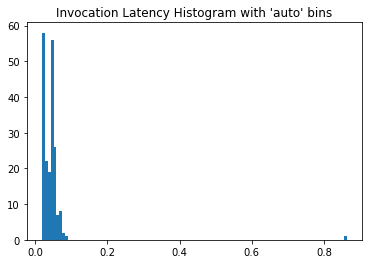

CPU times: user 2.7 s, sys: 121 ms, total: 2.82 s
Wall time: 9.29 s


In [17]:
%%time
# Real-time endpoint
_latency_hist_plot(realtime_endpoint_name, invocation_number)

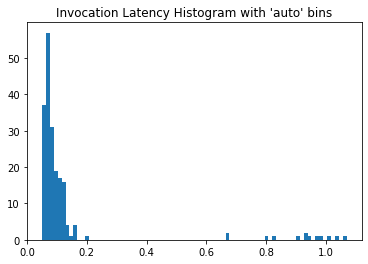

CPU times: user 2.26 s, sys: 124 ms, total: 2.39 s
Wall time: 27.9 s


In [18]:
%%time
# Serverless endpoint
_latency_hist_plot(serverless_endpoint_name, invocation_number)

### Results discussion
with serverless endpoint, the invocation latency is longer and there are more outliers in latency distribution

## Cold Endpoint invocation
If we wait 10-15 minutes and invoke the serverless endpoint, we will see 1st invocation taking longer than subsequent ones.

In [19]:
time.sleep(600)

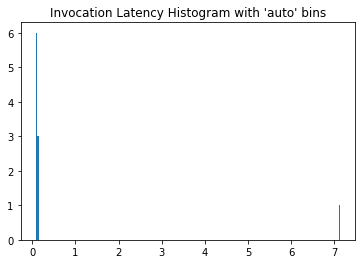

CPU times: user 630 ms, sys: 50 µs, total: 630 ms
Wall time: 8.68 s


In [20]:
%%time
# Serverless endpoint
_latency_hist_plot(serverless_endpoint_name, 10)

### Results discussion
First COLD invocation of a serverless end point take several seconds, after which the latency goes back to WARM invocation that we saw before

## Clean Up
Delete any resources you created in this notebook that you no longer wish to use.

In [23]:
#client.delete_model(ModelName=serverless_model_name)
#client.delete_endpoint_config(EndpointConfigName=xgboost_serverless_epc_name)
#client.delete_endpoint(EndpointName=serverless_endpoint_name)

{'ResponseMetadata': {'RequestId': '87c3d4ed-4529-4342-a590-10391ba59c94',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '87c3d4ed-4529-4342-a590-10391ba59c94',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 26 Jan 2022 18:23:16 GMT'},
  'RetryAttempts': 0}}

In [24]:
#inference_model.delete_model()
#client.delete_endpoint(EndpointName=realtime_endpoint_name)

{'ResponseMetadata': {'RequestId': '77171727-b007-4255-983b-64188c46c7f9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '77171727-b007-4255-983b-64188c46c7f9',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 26 Jan 2022 18:23:20 GMT'},
  'RetryAttempts': 0}}